# FAST HI观测规划助手`obshelper`示例4：OnOff两点切换

by astroR2 2025/5/10

* 示例4将介绍如何使用本程序包规划`OnOff`模式的观测。`Tracking`相对简单所以不介绍。

* 天顶角与合适的观测时间的检查请见另一个例子。

* 注意：本程序与FAST官方无关，纯个人开发使用，请仔细检查输出结果，如有错误概不负责。请务必先详细阅读[FAST观测常见问题](https://fast.bao.ac.cn/cms/article/147/)与[用户帮助文档](https://fast.bao.ac.cn/cms/article/80/)。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import hiviewer as hv
import os

from obshelper.opt_source import OptSource
from obshelper.utils.util import line_set

from astropy.coordinates import SkyCoord
from astropy import units as u

## 一个星系的OnOff观测

这里只是举个例子，不是真实的观测。NGC1234这个名字就能看出是我随便选的。

In [2]:
c = SkyCoord(47.412830, -7.846138, unit=(u.degree, u.degree))

opt = OptSource('NGC1234', c.ra.value, c.dec.value, vel = 3731)

In [3]:
pos = opt.center
print(pos.ra.to_string(unit = u.hourangle, sep = ':', precision=2, pad = True))
print(pos.dec.to_string(unit = u.degree, sep = ':', precision=1, pad = True))

03:09:39.08
-07:50:46.1


In [4]:
# 从NED下载附近40角分内有红移的星系
opt.iNED_box_url(sizex = 40, sizey = 40)

ra range 3.1164h 3.2053h
dec range -8.5128d -7.1795d
Please copy the ranges above and then click this url to jump: https://ned.ipac.caltech.edu/byparams


把这个txt转为astropy table方便读取的形式

In [5]:
tab = pd.read_csv('./data/NGC1234_40arcmin_NED_search.txt', sep = '|', comment='#')

tab.to_csv('./data/NGC1234_40arcmin_NED_search.csv', index = False)

下面我们来看下光学图像。如果发现交互功能不好用，一个是打开ipyaladin的网站参考下，另一种方法是换JupyterLab。

In [6]:
desi = 'CDS/P/DESI-Legacy-Surveys/DR10/color'
aladin = opt.ialadin(fov = 3/60, survey = desi,width='80%')
aladin

Aladin(fov=0.05, init_options=['background_color', 'coo_frame', 'fov', 'full_screen', 'grid_color', 'grid_opac…

此处标记了半径30角分以内的NED源与NVSS连续谱源。NED源限制了速度差的绝对值小于2000km/s

In [7]:
# 把catalog画上去
opt.retrive_table(r = 30, v = 2000, survey = 'ned_z', keys = ['RA', 'DEC', 'Velocity'], color = 'lightgreen',
                   tablename = './data/NGC1234_40arcmin_NED_search.csv')
opt.retrive_table(r = 30, survey = 'nvss', keys = ['_RAJ2000', '_DEJ2000'], color = 'red', 
                   tablename = '/data/inspur_disk04/FAST/xuc/FAST/catalogs/nvss_catalog.fit',)
# 画一个半径1.5角分的圆
opt.aladin.add_overlay_from_stcs(
    f"Circle ICRS {opt.ra} {opt.dec} {1.5 / 60}", color= "#4488ee"
    )

retrive table ned_z


added table.
retrive table nvss


added table.


效果如下图所示
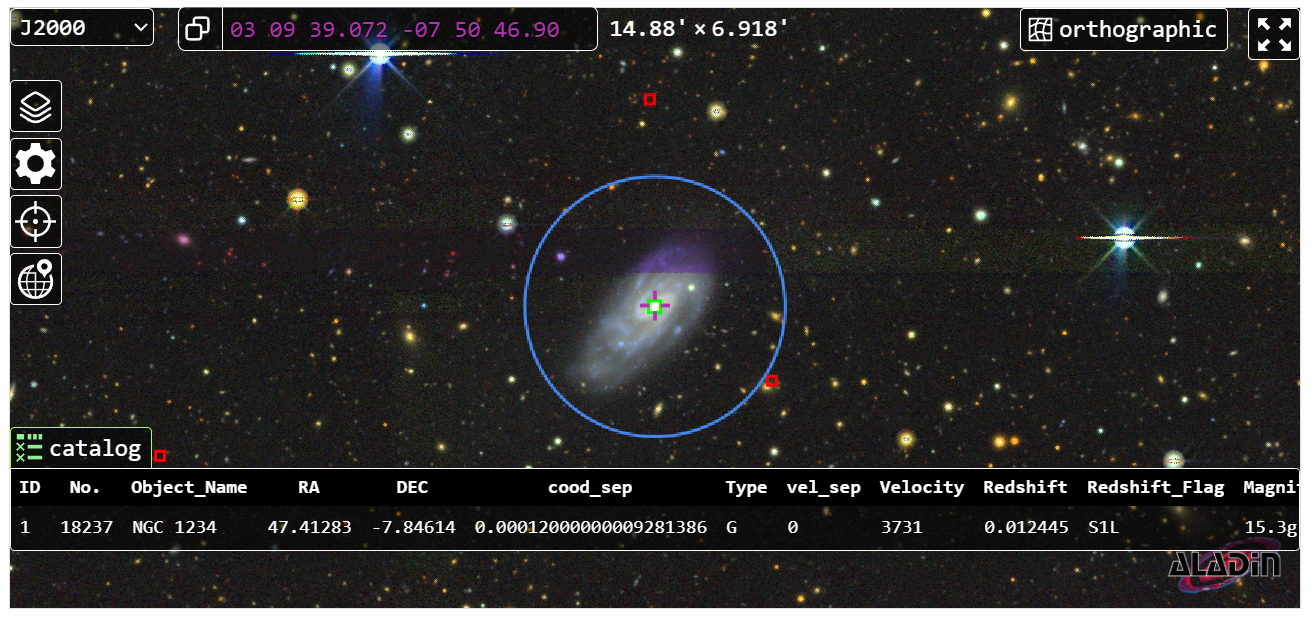

In [8]:
opt.tables['ned_z']

ID,No.,Object Name,RA,DEC,cood_sep,Type,vel_sep,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,,,,arcmin,,km / s,,,,,,,,,,,,
int64,int64,str30,float64,float64,float64,str6,float64,float64,float64,str3,str5,float64,int64,int64,int64,int64,int64,int64,int64
1,18237,NGC 1234,47.41283,-7.84614,0.00012000000009281386,G,0.0,3731.0,0.012445,S1L,15.3g,0.0,38,1,74,17,15,14,0
2,17811,SDSS J030935.20-075725.7,47.3967,-7.95715,6.729348120458554,G,-73.0,3804.0,0.01269,SLS,17.2g,0.0,16,0,33,7,6,4,0
3,10496,SDSS J030829.42-074917.2,47.12261,-7.82146,17.314121772304862,G,59.0,3672.0,0.01225,SLS,22.7g,0.0,2,0,5,1,1,4,0
4,10371,WISEA J030828.44-074908.1,47.1185,-7.81893,17.571043543767672,G,75.0,3656.0,0.012196,SLS,18.8g,0.0,20,0,74,9,7,14,0
5,10349,SDSS J030828.27-074910.4,47.1178,-7.81957,17.608941012953238,G,84.0,3647.0,0.012165,SLS,21.7g,0.0,3,0,15,1,1,4,0
6,30457,WISEA J031117.74-080448.1,47.82393,-8.08004,28.17251375045603,G,-248.0,3979.0,0.013271,SLS,16.6g,0.0,17,0,65,9,6,10,0


### off点的选择

当M01指在目标源上时，采用此时M08的位置作为source off时M01的中心是一种在相同的观测时间下使得积分时间加倍的方法，在[Zheng2020](https://academic.oup.com/mnras/article/499/3/3085/5917106)的文章中有详细表述。

source off时M08的对侧波束M14指在源上，所以M01的on与off，M14的on与off都可以互相减得到目标的谱线，二者加权平均可以得到更好的信噪比。注意M14是先观测off后观测on，使用`hifast`处理后需要手动添加负号。

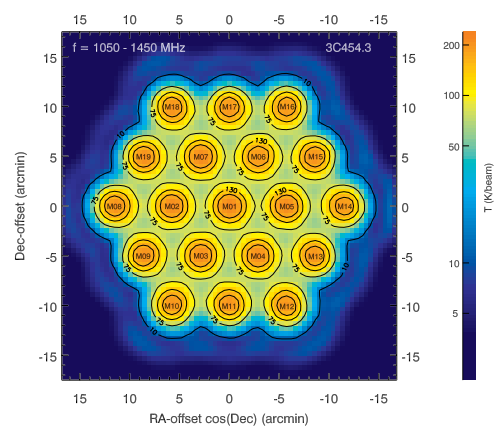

也可以根据实际情况挑选其它外圈波束作为off点。off点的条件应满足：
* 无接近速度其它可能有HI的星系；
* 无强连续谱源干扰。

外圈波束相比内圈波束更远，而换源时间在20角分内都相同，是划算的选择。如果没有符合的，那就任意选择距离合适的空场作为off点。

In [9]:
# 如果拿M01对准source时M08的位置当off，
from obshelper.utils.beamsep import beam_sep2center
coff = beam_sep2center(opt.center, beam = 'M08')

ra, dec = coff.ra.value, coff.dec.value
vel = 3731
off = OptSource('off', ra, dec, vel)

aladin_off = off.ialadin(fov = 3/60, survey= desi, width='80%')
aladin_off

M01 centered on 03h09m39.0792s -07d50m46.0968s
Moved M01 to M08's position as source off on 03h10m25.51391095s -07d50m47.3748s
Remember the beam as source on is on the other side!


Aladin(fov=0.05, init_options=['background_color', 'coo_frame', 'fov', 'full_screen', 'grid_color', 'grid_opac…

In [10]:
off.retrive_table(r = 30, v = 2000, survey = 'ned_z', keys = ['RA', 'DEC', 'Velocity'], color = 'lightgreen',
                   tablename = './data/NGC1234_40arcmin_NED_search.csv')
off.retrive_table(r = 30, survey = 'nvss', keys = ['_RAJ2000', '_DEJ2000'], color = 'red', 
                   tablename = '/data/inspur_disk04/FAST/xuc/FAST/catalogs/nvss_catalog.fit',)
off.aladin.add_overlay_from_stcs(
    f"Circle ICRS {off.ra} {off.dec} {1.5 / 60}", color= "#4488ee"
    )

retrive table ned_z
added table.
retrive table nvss
added table.


没有会影响off点的源，所以这个位置可以。
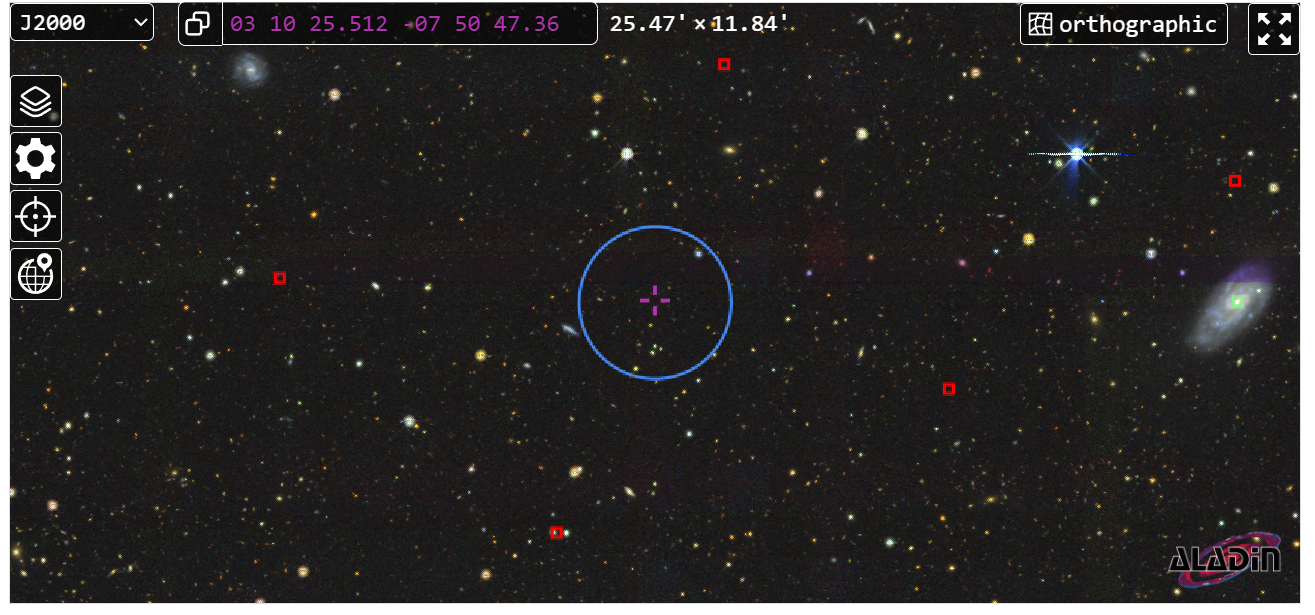

我们还需确保M14的位置也是干净的。

In [11]:
# 如果拿M01对准source时M14的位置当off，
from obshelper.utils.beamsep import beam_sep2center
coff2 = beam_sep2center(opt.center, beam = 'M14')

ra, dec = coff2.ra.value, coff2.dec.value
vel = 3731
off2 = OptSource('off', ra, dec, vel)

aladin_off2 = off2.ialadin(fov = 3/60, survey= desi, width='80%')
aladin_off2

M01 centered on 03h09m39.0792s -07d50m46.0968s
Moved M01 to M14's position as source off on 03h08m52.64448905s -07d50m46.1742s
Remember the beam as source on is on the other side!


Aladin(fov=0.05, init_options=['background_color', 'coo_frame', 'fov', 'full_screen', 'grid_color', 'grid_opac…

In [12]:
off2.retrive_table(r = 30, v = 2000, survey = 'ned_z', keys = ['RA', 'DEC', 'Velocity'], color = 'lightgreen',
                   tablename = './data/NGC1234_40arcmin_NED_search.csv')
off2.retrive_table(r = 30, survey = 'nvss', keys = ['_RAJ2000', '_DEJ2000'], color = 'red', 
                   tablename = '/data/inspur_disk04/FAST/xuc/FAST/catalogs/nvss_catalog.fit',)
off2.aladin.add_overlay_from_stcs(
    f"Circle ICRS {off2.ra} {off2.dec} {1.5 / 60}", color= "#4488ee"
    )

retrive table ned_z
added table.
retrive table nvss
added table.


都满足三角分左右内没有速度相近的星系，或者S1_4太强的NVSS源即可。

In [13]:
header = ["#Source Name", "Observation Mode", "ON RA(hh:mm:ss.ss)", "ON DEC(dd:mm:ss.s)", "OFF RA(hh:mm:ss.ss)", "OFF DEC(dd:mm:ss.s)", ]

df = pd.DataFrame(columns=header)
def format_radec(pos):
    ra1 = pos.ra.to_string(unit = u.hourangle, sep = ':', precision=2, pad = True)
    dec1 = pos.dec.to_string(unit = u.degree, sep = ':', precision=1, alwayssign = True, pad = True)
    return ra1, dec1


ra_on, dec_on = format_radec(opt.center)
ra_off, dec_off = format_radec(off.center)
df.loc[0] = [f"{opt.name}", "OnOff", ra_on, dec_on, ra_off, dec_off]

In [14]:
# 角距离11.5'
opt.center.separation(off.center)

<Angle 0.19166691 deg>

In [15]:
df

,#Source Name,Observation Mode,ON RA(hh:mm:ss.ss),ON DEC(dd:mm:ss.s),OFF RA(hh:mm:ss.ss),OFF DEC(dd:mm:ss.s)
0,NGC1234,OnOff,03:09:39.08,-07:50:46.1,03:10:25.51,-07:50:47.4


In [16]:
# 保存时不需要最后一列时间列
df[df.keys()[:-1]].to_csv('./obsfile/NGC1234_OnOff.txt', sep='|', index = False)